<h2><center>Comparison of Recommender System Algorithms on Amazon Reviews Dataset</center></h2>
<h5><center>Vibha Choudhary (vc1436@nyu.edu)</center></h5>


## Abstract  
Recommendation is an integral part that drives the business sales and industries do a great deal of research and development work in adopting machine learning technologies to improve their recommendation models. There are several recommendation techniques available and most of them are based on Collaborative filtering and Content-based filtering approaches. This project analyses and compares the performance of some of these recommendation models by also addressing the sparsity and cold start problems. The performance of these models are evaluated based on RMSE, MAE,MSE metrics.


# Table of contents
1. [Introduction](#intro)
2. [Dataset](#dataset)
    1. [Load Dataset](#load)
    2. [Data Exploration](#explore)
3. [Data Preparation](#prepare)
4. [Recommendation Techniques](#recommendation)
    1. [Baseline](#baseline)
    2. [Colloborative filtering - KNN](#cf_knn)
         1. [User-based](#cf_knn_user)
         2. [Item-based](#cf_knn_item)
    3. [Colloborative filtering - Kmeans](#cf_kmeans)
    4. [Matrix Factorisation - ALS](#als)
    5. [Content based filtering](#bert)
5. [Conclusion](#conclusion)
6. [Future Work](#future)

# 1. Introduction <a name="intro"></a>

Recommender systems have become a critical part of every business and they are widely used to support users in finding relevant information. Recommendation drives more purchases for a business than any other purchase influence. According to a <a href = 'https://www.mckinsey.com/industries/retail/our-insights/how-retailers-can-keep-up-with-consumers'>McKinsey report</a>, 35% of what consumers purchase on Amazon and 75% of what they watch on Netflix come from algorithmical product recommendations. Every business wants its consumers to have the best user experience when they browse or purchase products on their web platform. Netflix has spent years building and improving its recommendation engine and even sponsored a <a href = 'https://www.netflixprize.com/'>$1 million contest</a> to improve its algorithm.

Recommender systems aim to predict users’ interests and recommend product items that quite likely are interesting for them. Data required to build recommendation system can be available in either explicit (user ratings) or implicit form (users' browsing history, purchase history, click patterns, etc). One can also leverage the knowledge available about users/items to do recommendations. In this project, the explicit ratings given by the Amazon.com marketplace customers to the products are utilised to build the recommendation models and test their performances. 

The purpose of this project is to explore the different recommendation models on Amazon customer reviews dataset, understand how they work, compare their performances and address the problems associated with them. The following recommendation techniques have been analysed and tested:  
1. Popularity based model  
2. Collobarative filtering using KNN  
3. Colloborative filtering using Kmeans Clustering  
4. Matrix factorisation using ALS
5. Content-based filtering using BERT

This notebook is organised as follows. Section 2 of this notebook explores the dataset and perform exploratory analysis, section 3 focuses on preparation of data for machine learning models, section 4 discusses the recommendation techniques and their implemenadtion on the project dataset, section 5 provides a conclusion on the results and section 6 discusses future work.

## 2. The Dataset <a name="dataset"></a>

The dataset for this project is taken from the AWS Public dataset page. More details about this dataset can be found at <a href = 'https://s3.amazonaws.com/amazon-reviews-pds/readme.html'> Amazon Customer Reviews</a>. It consists of product reviews written in the Amazon.com marketplace from 1995 until 2015. There are over 130+ million customer reviews that are available to researchers as part of this release. The reviews are partitioned by product_category and are available to download in the tsv (tab separated value) format. For this project, reviews of 3 product categories (Home, Electronics and Mobile Electronics) are utilised.

In [1]:
import os
project_dir = "C:/Users/Vibha Khatri/Desktop/ML book/Project/data"
home = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_v1_00.tsv.gz"
mob_electronics = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz"
electronics = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz"

#download files
! curl home --output os.path.join(project_dir, "Home.tsv.gz") --silent
! curl mob_electronics --output os.path.join(project_dir, "Mobile_Electronics.tsv.gz") --silent
! curl electronics --output os.path.join(project_dir, "Electronics.tsv.gz") --silent

### Dataset features  <a name="load"></a>


There are 15 features in the dataset which are described as follows:
 - marketplace - 2 letter country code of the marketplace where the review was written.  
 - review_id - The unique ID of the review.  
 - customer_id - Random identifier that can be used to aggregate reviews written by a single author.  
 - product_id - The unique Product ID the review pertains to.  
 - product_parent - Random identifier that can be used to aggregate reviews for the same product.  
 - product_title - Title of the product.  
 - product_category - Broad product category that can be used to group reviews.  
 - star_rating - The 1-5-star rating of the review.  
 - helpful_votes - Number of helpful votes.  
 - total_votes - Number of total votes the review received.  
 - vine - Review was written as part of the Vine program.  
 - verified_purchase - The review is on a verified purchase.  
 - review_headline - The title of the review.  
 - review_body - The review text.  
 - review_date - The date the review was written.   
 
The features important for this project are:  
 - customer_id, product_id, product_category, product_title, star_rating


In [2]:
# load dataset into dataframes
import pandas as pd
file_path1 = os.path.join(project_dir, "Electronics.tsv")
file_path2 = os.path.join(project_dir, "Mobile_Electronics.tsv")
file_path3 = os.path.join(project_dir, "Home.tsv")

use_cols = ['review_id', 'customer_id', 'product_id', 'product_title', 'product_category', 'star_rating', 'review_date']
df1 = pd.read_csv(file_path1, sep='\t+', encoding='utf-8', header=0, engine = 'python', usecols = use_cols, error_bad_lines = False)
df2 = pd.read_csv(file_path2, sep='\t+', encoding='utf-8', header=0, engine = 'python', usecols = use_cols, error_bad_lines = False)
df3 = pd.read_csv(file_path3, sep='\t+', encoding='utf-8', header=0, engine = 'python', usecols = use_cols, error_bad_lines = False)

# remove null data
df1 = df1[df1['review_date'].notnull()]
df2 = df2[df2['review_date'].notnull()]
df3 = df3[df3['review_date'].notnull()]

# extract year information
df1['year'] = df1['review_date'].str.slice(0, 4)
df2['year'] = df2['review_date'].str.slice(0, 4)
df3['year'] = df3['review_date'].str.slice(0, 4)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# define plot functions

def plot_ratings_distribution():
    for j,col in enumerate(['star_rating','year']):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (24,6)) 
        fig.suptitle(str(col +" distribution"), fontsize=16)
        for ix, frame in enumerate([df1,df2,df3]): 
            rat = frame[col].value_counts().to_frame()
            rat.columns = ['count']
            rat.index.name = col
            rat.reset_index(level=0, inplace=True)
            rat['percent'] = rat['count'] * 100 / rat['count'].sum() 
            sns.barplot(x=col, y="percent", data=rat, ax=ax[ix])
            ax[ix].set_title(frame.loc[0,'product_category'])
            ax[ix].set_ylabel('Percent')
            ax[ix].set_xticklabels(ax[ix].get_xticklabels(), rotation=90, horizontalalignment='left')
            
def plot_reviews_distribution():            
    for j,col in enumerate(['product','customer']):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (24,6)) 
        fig.suptitle(str("Per " + col +" reviews count"), fontsize=16)
        if col == 'product':
            range = [1, 2500]
        else:
            range = [1, 50]
        for ix, frame in enumerate([df1,df2,df3]):    
            reviews = frame[col + "_id"].value_counts().to_frame()
            reviews.columns = ['count']
            ax[ix].hist(x=reviews['count'], bins=100, rwidth=0.9,
                           color='#607c8e', range=range)
            ax[ix].set_title(frame.loc[0,'product_category'])
            ax[ix].set_xlabel('Reviews')
            ax[ix].set_ylabel('Frequency')
            ax[ix].grid(axis='y', alpha=0.8)

### Dataset exploration <a name="explore"></a>


The reviews data of Electronics, Mobile Electronics and Home categories are analysed to get the insights from the data. 

#### Electronics dataset

In [4]:
df1.head(3)

,customer_id,review_id,product_id,product_title,product_category,star_rating,review_date,year
0,41409413,R2MTG1GCZLR2DK,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,2015-08-31,2015
1,49668221,R2HBOEM8LE9928,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,2015-08-31,2015
2,12338275,R1P4RW1R9FDPEE,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,2015-08-31,2015


#### Mobile Electronics dataset

In [5]:
df2.head(3)

,customer_id,review_id,product_id,product_title,product_category,star_rating,review_date,year
0,20422322,R8MEA6IGAHO0B,B00MC4CED8,BlackVue DR600GW-PMP,Mobile_Electronics,5,2015-08-31,2015
1,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5,2015-08-31,2015
2,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,iXCC Multi pack Lightning cable,Mobile_Electronics,5,2015-08-31,2015


#### Home dataset

In [6]:
df3.head(3)

,customer_id,review_id,product_id,product_title,product_category,star_rating,review_date,year
0,33670092,R1UUISQ1GKOJTI,B00EE62UAE,"Trademark Home Portable Closet, White",Home,1,2015-08-31,2015
1,13726692,R1HOJ9WE8VCVOD,B001APXO5C,O2-Cool 10-Inch Portable Fan,Home,5,2015-08-31,2015
2,50131396,RDNGVXMWQN2TN,B002HFDLCK,Hoover Vacuum Cleaner T-Series Windtunnel Rewi...,Home,5,2015-08-31,2015


### Ratings distribution

By plotting the reviews by ratings and year, one can observe that the ratings received in all the three categories of products mostly lie in the range of 3 and 5. The years that received most of the reviews lie in the range 2007 and 2017.


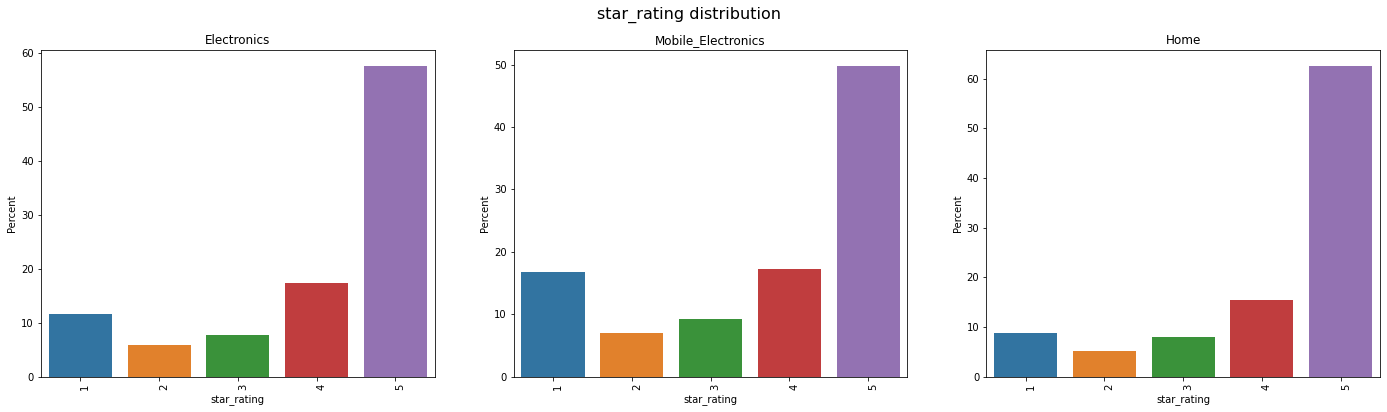

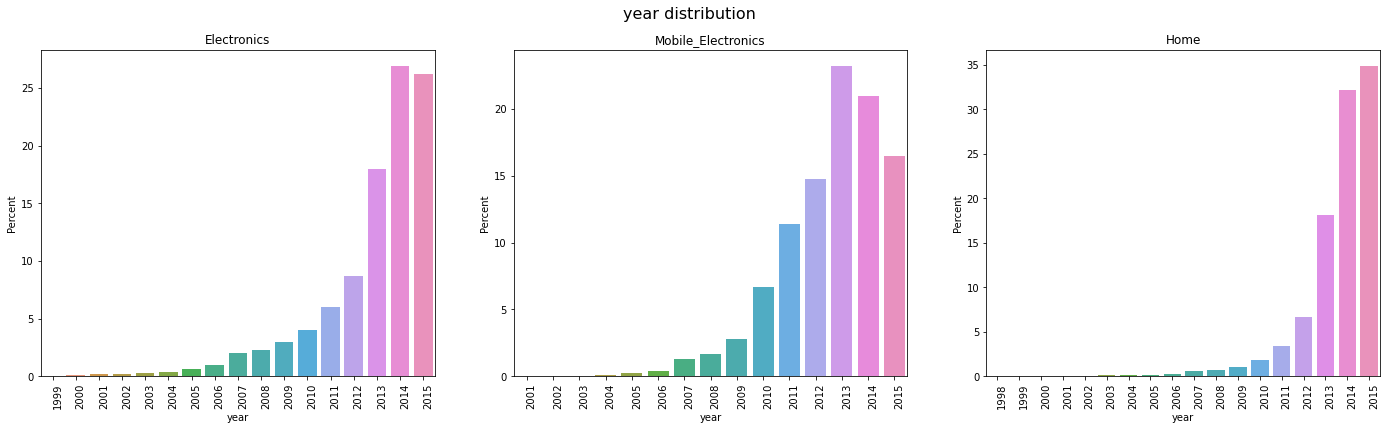

In [7]:
plot_ratings_distribution()

### Per product and customer reviews

Most recommender systems face problems with shortage of reviews. To see if our current dataset faces such problem the distribution of reviews are plotted on per product and per customer basis and the results show that there is definitely shortage of reviews in our dataset. Not many products have received reviews greater than 100 and not many customers have given more than 10 reviews.

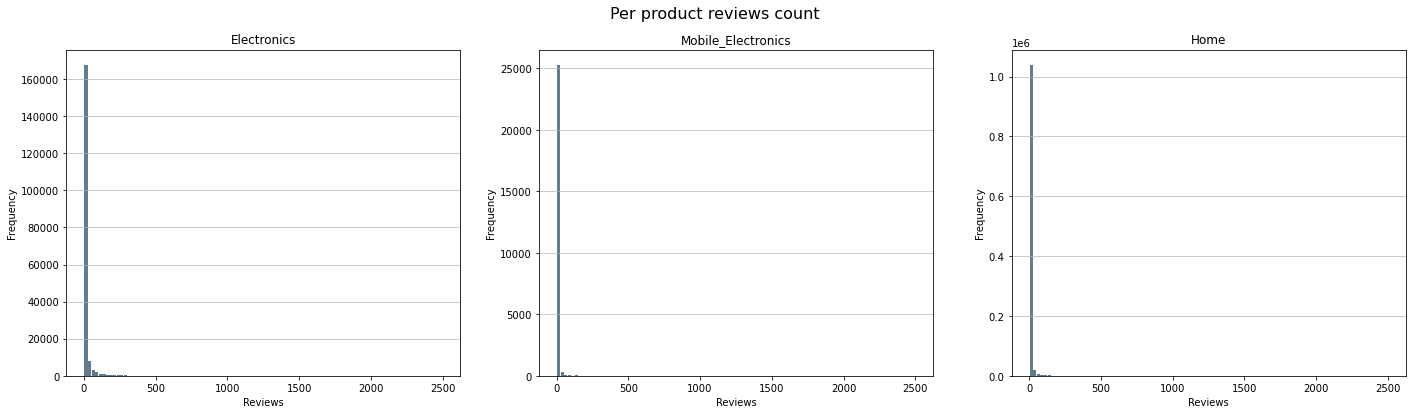

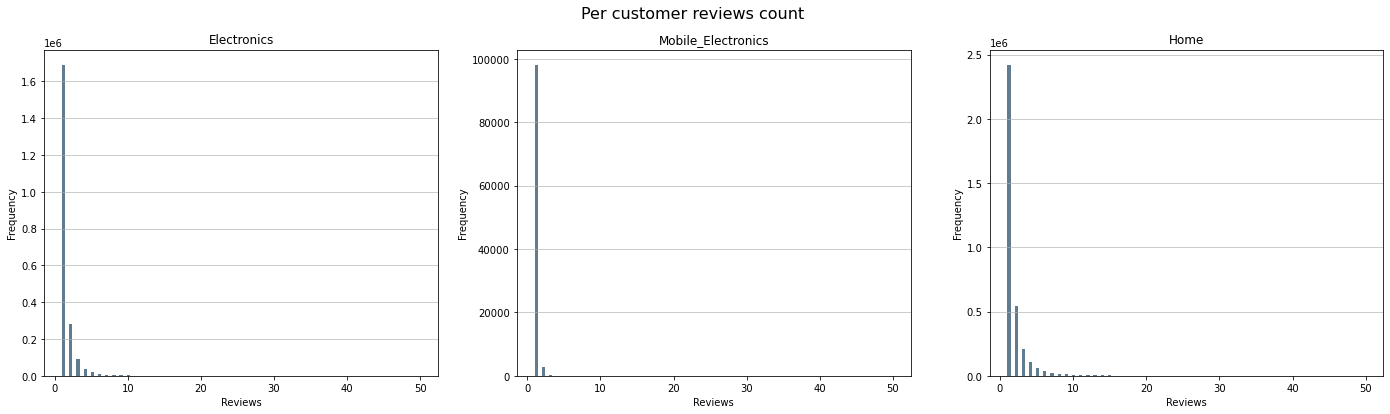

In [8]:
plot_reviews_distribution()

# 3. Data Preparation  <a name="prepare"></a>
The reviews from all the three product categories are combined in a single dataset and the combined reviews distribution is shown in the below plots. To prepare data for the recommendation models and for better evaluation of the models, the dataset is filtered to include only those users who have given atleast 5 reviews and those products which have received atleast 200 reviews. The training and test datasets are prepared for both user based and item based approaches where dataset is stratified based on users in the former approach and it is stratified based on items in the later approach.

In [9]:
# Data Preparation
from sklearn.model_selection import train_test_split

# combine reviews of 3 categories
reviews_data = pd.concat([df1,df2,df3])
df1, df2, df3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# plot final distribution
def plot_combined_distribution():
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (30,6)) 
    for ix, col in enumerate(['star_rating','year','product_id','customer_id']):
        reviews = reviews_data[col].value_counts().to_frame()
        reviews.columns = ['count']
        reviews.index.name = col
        reviews.reset_index(level=0, inplace=True)
        reviews['percent'] = reviews['count'] * 100 / reviews['count'].sum()
        if col in ('star_rating','year'):
            sns.barplot(x=col, y="percent", data=reviews, ax=ax[ix])
            ax[ix].set_title(col + " distribution")
            ax[ix].set_ylabel('Percent')
            ax[ix].set_xticklabels(ax[ix].get_xticklabels(), rotation=90, horizontalalignment='left')
        else:
            if col == 'product_id':
                range = [1, 500]
            else:
                range = [1, 50]
            ax[ix].hist(x=reviews['count'], bins=100, rwidth=0.9,
                           color='#607c8e', range=range)
            ax[ix].set_title("Per " + col + " reviews count")
            ax[ix].set_xlabel('Reviews')
            ax[ix].set_ylabel('Frequency')
            ax[ix].grid(axis='y', alpha=0.8)  
            
# filter dataset to exclude cutomers and products
def filter_reviews_data_user_based():  
    filtered_data = reviews_data.loc[:,['customer_id', 'product_id', 'product_title', 'product_category', 'star_rating']]
    # exclude products with less than 200 reviews
    product_reviews_count = filtered_data['product_id'].value_counts().to_frame()
    product_reviews_count.columns = ['review_count']
    product_reviews_count.index.name = 'product_id'
    product_reviews_count.reset_index(level=0, inplace=True)
    exclude_products = product_reviews_count[product_reviews_count['review_count'] < 200]['product_id'].to_frame()
    filtered_data = filtered_data[~(filtered_data.product_id.isin(exclude_products.product_id))]

    # exclude customer with less than 5 reviews
    user_reviews_count = filtered_data['customer_id'].value_counts().to_frame()
    user_reviews_count.columns = ['review_count']
    user_reviews_count.index.name = 'customer_id'
    user_reviews_count.reset_index(level=0, inplace=True)
    exclude_users = user_reviews_count[user_reviews_count['review_count'] < 5]['customer_id'].to_frame()
    filtered_data = filtered_data[~(filtered_data.customer_id.isin(exclude_users.customer_id))]
    return filtered_data

# filter dataset to exclude cutomers and products
def filter_reviews_data_item_based():  
    filtered_data = reviews_data.loc[:,['customer_id', 'product_id', 'product_title', 'product_category', 'star_rating']]
    # exclude customer with less than 5 reviews
    user_reviews_count = filtered_data['customer_id'].value_counts().to_frame()
    user_reviews_count.columns = ['review_count']
    user_reviews_count.index.name = 'customer_id'
    user_reviews_count.reset_index(level=0, inplace=True)
    exclude_users = user_reviews_count[user_reviews_count['review_count'] < 5]['customer_id'].to_frame()
    filtered_data = filtered_data[~(filtered_data.customer_id.isin(exclude_users.customer_id))]
    
    # exclude products with less than 200 reviews
    product_reviews_count = filtered_data['product_id'].value_counts().to_frame()
    product_reviews_count.columns = ['review_count']
    product_reviews_count.index.name = 'product_id'
    product_reviews_count.reset_index(level=0, inplace=True)
    exclude_products = product_reviews_count[product_reviews_count['review_count'] < 200]['product_id'].to_frame()
    filtered_data = filtered_data[~(filtered_data.product_id.isin(exclude_products.product_id))]
    return filtered_data

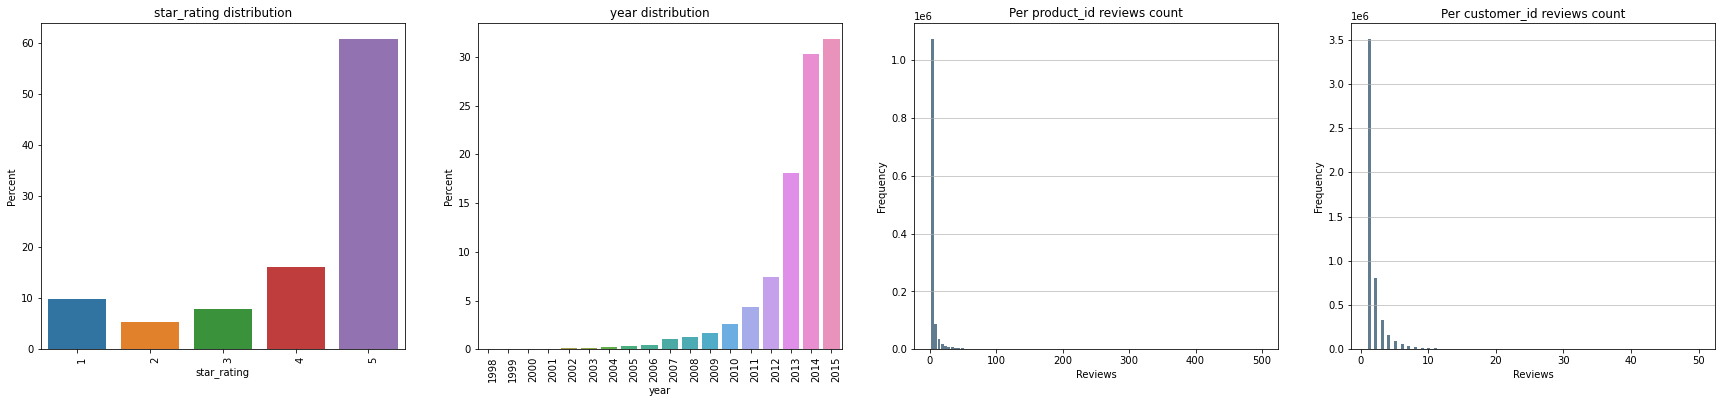

In [10]:
plot_combined_distribution()

In [12]:
reviews_data = filter_reviews_data_user_based()
print("Total reviews", reviews_data.shape)
print("Total unique customers", reviews_data.customer_id.unique().size)
print("Total unique products", reviews_data.product_id.unique().size)

Total reviews (254273, 5)
Total unique customers 37241
Total unique products 5514


### Train / Test split

The combined reviews dataset is split into training and test dataset into 70:30 ratio. To ensure that the proportion of each user's reviews is the same in both the training and testing datasets, the customer_id is treated as the target variable and the dataset is stratified along the customer_id.

### User based split

In [13]:
filter_data = filter_reviews_data_user_based()
X_train, X_test, y_train, y_test = train_test_split(filter_data, filter_data['customer_id'], test_size = 0.30, random_state=42,
                                                    stratify=filter_data['customer_id'] )
X_train.to_csv(os.path.join(project_dir, "X_train.csv"))
X_test.to_csv(os.path.join(project_dir, "X_test.csv"))
y_train.to_csv(os.path.join(project_dir, "y_train.csv"))
y_test.to_csv(os.path.join(project_dir,"y_test.csv"))

In [14]:
print("Training dataset shape: ", X_train.shape)
print("Test dataset shape: ", X_test.shape)
print("Unique customers in train dataset: ", X_train.customer_id.unique().size)
print("Unique products in train dataset: ", X_train.product_id.unique().size)
print("Unique customers in test dataset: ", X_test.customer_id.unique().size)
print("Unique products in test dataset: ", X_test.product_id.unique().size)

Training dataset shape:  (177991, 5)
Test dataset shape:  (76282, 5)
Unique customers in train dataset:  37241
Unique products in train dataset:  5513
Unique customers in test dataset:  37241
Unique products in test dataset:  5454


### Item based split

In [13]:
filter_data = filter_reviews_data_item_based()
X_train, X_test, y_train, y_test = train_test_split(filter_data, filter_data['product_id'], test_size = 0.30, random_state=42,
                                                    stratify=filter_data['product_id'] )
X_train.to_csv(os.path.join(project_dir, "X_train1.csv"))
X_test.to_csv(os.path.join(project_dir, "X_test1.csv"))
y_train.to_csv(os.path.join(project_dir, "y_train1.csv"))
y_test.to_csv(os.path.join(project_dir,"y_test1.csv"))

In [14]:
print("Training dataset shape: ", X_train.shape)
print("Test dataset shape: ", X_test.shape)
print("Unique customers in train dataset: ", X_train.customer_id.unique().size)
print("Unique products in train dataset: ", X_train.product_id.unique().size)
print("Unique customers in test dataset: ", X_test.customer_id.unique().size)
print("Unique products in test dataset: ", X_test.product_id.unique().size)

Training dataset shape:  (177991, 5)
Test dataset shape:  (76282, 5)
Unique customers in train dataset:  37241
Unique products in train dataset:  5513
Unique customers in test dataset:  37241
Unique products in test dataset:  5454


# 4. Recommendation methods <a name="recommendation"></a>

Recommendation problem is treated as a prediction problem where the system predicts what rating a user will give to an item. If the recommender system is able to predict the rating accurately, it will be able to give great recommendations. There are two major paradigms of recommender systems : collaborative and content based methods. Out of the five models, the three models: CF using KNN, CF using KMeans and Matrix Factorisation using ALS are colloborative based methods. They will be discussed in the later sections. The first model that we can analyse is the Popularity based method which will be treated as the baseline for other methods. To evaluate the performance of all models we will measure the ratings prediction accuracy using Root Mean Squared Error (RMSE) , Mean Absolute Error (MAE) and Mean Squared error (MSE).


## Model 1 - Popularity Based Method (Baseline) <a name="baseline"></a>

Popularity based recommendation system works with the trend. In this recommendation technique, items are recommended to users based on how popular those items are among other users. The assumption here is that the products that have the most number of ratings or reviews are the most popular. Below plot shows that the ratings of products in our dataset are on a higher side with mean rating lying in the range of 4 and 4.5. In this model, to predict the rating of a product by a customer, we will simply return the average rating of that product.
The problems with popularity based recommendation system is that the personalization is not available with this method. It doesn't take into account user personal tastes and recommendations are same to all users.

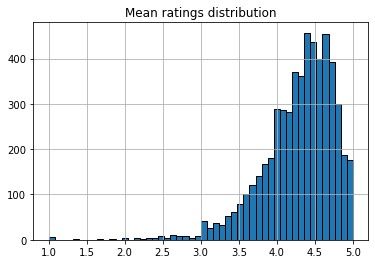

In [20]:
X_train = pd.read_csv(os.path.join(project_dir, "X_train.csv"), header=0, engine='python')
X_test = pd.read_csv(os.path.join(project_dir, "X_test.csv"), header=0, engine='python')
y_train = pd.read_csv(os.path.join(project_dir, "y_train.csv"), header=0, engine='python')
y_test = pd.read_csv(os.path.join(project_dir, "y_test.csv"), header=0, engine='python')  
ratings_mean_count = pd.DataFrame(X_train.groupby('product_id')['star_rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(X_train.groupby('product_id')['star_rating'].count())
plt.figure(figsize=(6,4))
plt.rcParams['patch.force_edgecolor'] = True
plt.title("Mean ratings distribution")
ratings_mean_count['star_rating'].hist(bins=50)

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# function to compute the root mean squared error (or RMSE)
def rmse(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

# function to compute the mean squared error (or MSE)
def mse(y_true, y_pred):    
    return mean_squared_error(y_true, y_pred)

# function to compute the mean absolute error (or MSE)
def mae(y_true, y_pred):    
    return mean_absolute_error(y_true, y_pred)

# function to compute the evaluation scores obtained on the testing set by a model
def score(model):
    # Predict the rating for every customer-product in X_test  
    test = X_test.apply(lambda row: model.getPredictions(row['customer_id'], row['product_id']), axis=1)
    # Return the final score 
    true = np.array(X_test['star_rating'])
    pred = np.array(test)
    rms =  rmse(true, pred)
    ms  =  mse(true, pred)
    ma = mae(true, pred)
    return rms, ms, ma

class Baseline:    
    # return average rating of the product in the system
    def getPredictions(self, customer_id, product_id):
        #Check if product_id exists in X_train
        if product_id in X_train['product_id']:
            #Compute the mean of all the ratings given to the product_id
            mean_rating = X_train[X_train.product_id == product_id]['star_rating'].mean()
        else:        
            #Default to a rating of 3.0 in the absence of any information
            mean_rating = 3.0        
        return mean_rating
     
    # return top N recommendations from X_train
    def getNRecommendations(self, n, customer_id):
        popular_products = pd.DataFrame(X_train.groupby(['product_id','product_title','product_category'])['star_rating'].count()).reset_index()        
        popular_products['mean_rating'] = pd.DataFrame(X_train.groupby(['product_id','product_category','product_title'])['star_rating'].mean()).reset_index()['star_rating']
        popular_products.columns = ['product_id','product_title','product_category','reviews_count','mean_rating']
        most_popular = popular_products.sort_values(['mean_rating','reviews_count'], ascending=False)
        return most_popular.head(n)

### Evaluation

In [17]:
baseline = Baseline()
rms, ms, ma = score(baseline)
print("Results using Popularity based model:\n")
print("Root Mean Square Error: ", rms)
print("Mean Square Error: ", ms)
print("Mean Absolute Error: ", ma)

Results using Popularity based model:

Root Mean Square Error:  1.7436337099458434
Mean Square Error:  3.0402585144595053
Mean Absolute Error:  1.6302797514485725


In [18]:
baseline.getNRecommendations(10, 13343)

,product_id,product_title,product_category,reviews_count,mean_rating
338,B00029U1DU,Verbatim 700MB 52X 80 Minute Branded Recordabl...,Electronics,45,5.0
2448,B0036OQU2E,Copco Non-Skid Cabinet Turntable,Home,31,5.0
55,B00005113L,"Cables To Go 18 AWG Universal Power Cord, IEC3...",Electronics,30,5.0
391,B0002XD08Y,"simplehuman Under-Counter Pull-Out Trash Can, ...",Home,29,5.0
3559,B005LJQO9G,HDMI-DVI Cables,Electronics,25,5.0
1803,B001MSU1HQ,Mediabridge RCA Component Video Cable with Audio,Electronics,23,5.0
4657,B00BWJCCI6,Sizzix Big Shot Cutting and Embossing Roller S...,Home,22,5.0
640,B000CR38Y6,Willow Tree Promise,Home,17,5.0
1217,B000WV1XGC,Clover Large Pom Pom Maker,Home,15,5.0
5490,B00RH340WM,French Coffee & TeaMaker Complete Bundle | 34 ...,Home,15,5.0


## Model 2 - Collaborative filtering using KNN <a name="cf_knn"></a>

Colloborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (colloborating) [from Wikipedia]. This technique is based on the assumption that users who have agreed in the past tend to also agree in future.  
<img src="CF1.png"  width="450" height="450" align="center">  

The data is divided into two categories users and the items. The ratings given by users to the items are collected in a matrix called utility matrix or user-item matrix. The resulting matrix is sparse and is filled with zero for all the missing values.  
The two approaches for colloborating filtering are <b>User-based</b> and <b>Item-based</b>. Item-based collaborative filtering was developed by Amazon. In a system where there are more users than items, item-based filtering is faster and more stable than user-based. It is effective because usually, the average rating received by an item doesn’t change as quickly as the average rating given by a user to different items.<img src="UI.png"  width="450" height="450" align="center"> 


### User-based approach <a name="cf_knn_user"></a>

In the implementation of user-based colloborative filtering using KNN recommendation technique, the customers are placed in rows and the products are placed in columns of the utility matrix. There are 37241 customers and 5541 products in our filtered dataset. Using nearest neighbors size as 20 (k = 20), the score of the model is calculated. So, if we want to predict what rating will user u1 give to item i1 then closest 20 neighbors of u1 are computed who rated item i1 and based on those ratings final rating of u1 is predicted.

In [22]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

#User Based Collaborative Filter using Nearest Neighbours
class CollaborativeUserKNN:
    def __init__(self):
        self.knn =  NearestNeighbors(metric='cosine', algorithm='brute')
        
    def fit(self, data):
        self.nbrs = self.knn.fit(data)
        
    def getNeighbors(self, data, k):
        distances,indices = self.nbrs.kneighbors(data, n_neighbors = k)
        return distances,indices
    
    def getPredictions(self, customer_id, product_id):
         #Check if product_id exists in r_matrix
        if product_id in r_matrix:
            #Get distances of all the users
            distances,indices =  self.getNeighbors(r_matrix.loc[customer_id,:].values.reshape(1,-1),20)
            sample = pd.DataFrame([distances.flatten(),indices.flatten()]).T
            sample.columns = ['distance', 'customer_id']
            sample = sample.astype({"customer_id": int}) 
            sample['customer_id'] = sample['customer_id'].apply(lambda x: r_matrix.iloc[x].name)
            s = 0.0
            cnt = 0
            for c in sample['customer_id']:
                val = r_matrix.loc[c, product_id]
                if val > 0:
                    s += val
                    cnt += 1
            if s == 0.0: 
                mean_rating = 3.0
            else:
                mean_rating = round(s/cnt,1)
        else:        
            #Default to a rating of 3.0 in the absence of any information
            mean_rating = 3.0        
        return mean_rating
    
    def getNRecommendations(self, n, customer_id):
        # get customer index
        r_mat = r_matrix.reset_index()
        idx = r_mat[r_mat.customer_id == customer_id].index.values[0]
        # get all products customer not reviwed
        plist = r_mat.iloc[idx,:][map(lambda x :x not in ['customer_id'], list(r_mat.columns))].to_frame().reset_index()
        r_mat = pd.DataFrame()
        plist.columns = ['product', 'rating']
        plist = np.array(plist[plist.rating==0]['product'])
        rec = []
        for product in plist:
            rec.append([product, self.getPredictions(customer_id, product)])
        rec = pd.DataFrame(rec, columns=['product_id','rating'])
        
        def getCount(p):
            return np.count_nonzero(r_matrix.loc[:,[p]])
        rec['count'] =  rec['product_id'].apply(getCount)
        most_popular = rec.sort_values(['rating','count'],ascending=False).iloc[:n,:]
        most_popular = pd.merge(most_popular, product_data[['product_id', 'product_title', 'product_category']],
                how='left', on=['product_id'])
        return most_popular 
    
X_train = pd.read_csv(os.path.join(project_dir, "X_train.csv"), header=0, engine='python')
X_test = pd.read_csv(os.path.join(project_dir, "X_test.csv"), header=0, engine='python')
y_train = pd.read_csv(os.path.join(project_dir, "y_train.csv"), header=0, engine='python')
y_test = pd.read_csv(os.path.join(project_dir, "y_test.csv"), header=0, engine='python') 
product_data = pd.DataFrame(X_train.groupby(['product_id', 'product_category', 'product_title'])['star_rating'].count()).reset_index().loc[:,['product_id', 'product_category', 'product_title']]


In [23]:
# Build the ratings matrix
r_matrix = X_train.groupby(['customer_id','product_id'])['star_rating'].min().unstack('product_id', fill_value=0)
knn = CollaborativeUserKNN()
knn.fit(csr_matrix(r_matrix.values))

In [24]:
rms, ms, ma = score(knn)
print("Results using user-based CF-KNN model:\n")
print("Root Mean Square Error: ", rms)
print("Mean Square Error: ", ms)
print("Mean Absolute Error: ", ma)

Results using CF-KNN model:

Root Mean Square Error:  1.7279297810470957
Mean Square Error:  2.985741328229464
Mean Absolute Error:  1.5828032825568286


In [25]:
knn.getNRecommendations(10, 13343)

,product_id,rating,count,product_title,product_category
0,B003L1ZYYW,5.0,296,AmazonBasics High Speed HDMI Cable,Electronics
1,B002HFA5F6,5.0,117,Hoover Vacuum Cleaner T-Series WindTunnel Pet ...,Home
2,B0019FOUQ0,5.0,113,"Whitmor Over-The-Door Shoe Rack, 36-Pair, White",Home
3,B003PWS9AI,5.0,86,SafeRest Premium Hypoallergenic Waterproof Mat...,Home
4,B00451BNUG,5.0,63,InterDesign Classico - Free Standing Toilet Pa...,Home
5,B003EXSTXA,5.0,62,GREEN LABEL 1 & 1/4 INCH DELUXE FLOOR BRUSH,Home
6,B0014SQVKK,5.0,59,Kirby Vacuum Cleaner Belts,Home
7,B000PS8QTO,5.0,49,Zenith Tension Shower Rod,Home
8,B0041D7OSS,5.0,37,Casabella Toilet Bowl Brush with Holder Set,Home
9,B005EVVMMA,5.0,35,Bluecell Black/Blue/Pink Earphone in-ear Hard ...,Electronics


### Item-based approach  <a name="cf_knn_item"></a>

In the item-based implementation of colloborative filtering using KNN, the utility matrix formulation has products placed in the rows and customers in the columns. To predict the rating of user u1 for item i1, the model tries to find 20 nearest  neighbors of item i1 that have been rated by user u1 and based on those ratings the rating for i1 is predicted.

In [119]:
class CollaborativeItemKNN:
    def __init__(self):
        self.knn =  NearestNeighbors(metric='cosine', algorithm='brute')
        
    def fit(self, data):
        self.nbrs = self.knn.fit(data)
        
    def getNeighbors(self, data, k):
        distances,indices = self.nbrs.kneighbors(data, n_neighbors = k)
        return distances,indices
    
    def getPredictions(self, customer_id, product_id):
        mean_rating = 3.0 

         #Check if customer_id exists in r_matrix
        if customer_id in r_matrix:
            # get all products customer reviewed
            plist = X_train[X_train.customer_id == customer_id]['product_id'].to_frame()
            def cosine_distance(pro):
                return cosine(r_matrix.loc[product_id,:].values.reshape(1,-1), 
                                                                r_matrix.loc[pro,:].values.reshape(1,-1))
            # get all simmilar products to the current product
            plist.loc[:,'distance'] = plist['product_id'].apply(cosine_distance)

            #get all products distances
            plist.loc[:,'rating'] = plist.loc[:,'product_id'].apply(lambda x: r_matrix.loc[x,customer_id])
            plist.sort_values(by='distance', ascending=True)
            
            # return mean rating of top 20
            mean_rating = plist.head(20)['rating'].mean()
        else:
            mean_rating = 3.0
        return mean_rating
    
    def getNRecommendations(self, n, customer_id):
        # get customer index
        plist = X_train[X_train.customer_id == customer_id]['product_id'].to_frame()
        plist = X_train[~(X_train.product_id.isin(plist.product_id))]
        plist = pd.DataFrame(plist.groupby(['product_id'])['star_rating'].count().reset_index())
        rec = []
        for product in np.array(plist.loc[:,'product_id']):
            rec.append([product, self.getPredictions(customer_id, product)])
        rec = pd.DataFrame(rec, columns=['product_id','rating'])

        def getCount(p):
            return plist[plist.product_id == p]['star_rating'].values[0]
        rec['count'] =  rec['product_id'].apply(getCount)
        most_popular = rec.sort_values(['rating','count'],ascending=False).iloc[:n,:]
        most_popular = pd.merge(most_popular, product_data[['product_id', 'product_title', 'product_category']],
                how='left', on=['product_id'])
        return most_popular
    
X_train = pd.read_csv(os.path.join(project_dir, "X_train1.csv"), header=0, engine='python')
X_test = pd.read_csv(os.path.join(project_dir, "X_test1.csv"), header=0, engine='python')
y_train = pd.read_csv(os.path.join(project_dir, "y_train1.csv"), header=0, engine='python')
y_test = pd.read_csv(os.path.join(project_dir, "y_test1.csv"), header=0, engine='python')
product_data = pd.DataFrame(X_train.groupby(['product_id', 'product_category', 'product_title'])['star_rating'].count()).reset_index().loc[:,['product_id', 'product_category', 'product_title']]


In [120]:
# Build the ratings matrix
r_matrix = X_train.groupby(['product_id','customer_id'])['star_rating'].min().unstack('customer_id', fill_value=0)
knn = CollaborativeItemKNN()
knn.fit(csr_matrix(r_matrix.values))

In [107]:
rms, ms, ma = score(knn)
print("Results using item-based CF-KNN model:\n")
print("Root Mean Square Error: ", rms)
print("Mean Square Error: ", ms)
print("Mean Absolute Error: ", ma)

Results using item-based CF-KNN model:

Root Mean Square Error:  1.47272693450667
Mean Square Error:  2.1689246236214133
Mean Absolute Error:  1.0978313798765642


In [121]:
knn.getNRecommendations(10, 13343)

,product_id,rating,count,product_title,product_category
0,B003L1ZYYM,5.0,3232,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,Electronics
1,B0002L5R78,5.0,1777,High Speed HDMI Cable (1.5 Feet) With Ethernet...,Electronics
2,B0013BKDO8,5.0,1490,AcuRite 00613 Humidity Monitor with Indoor The...,Home
3,B0052SCU8U,5.0,1401,AmazonBasics High Speed HDMI Cable,Electronics
4,B0012S4APK,5.0,1360,"Cheetah APTMM2B TV Wall Mount for 20-75"" TVs u...",Electronics
5,B001TH7GSW,5.0,1349,AmazonBasics Digital Optical Audio Toslink Cab...,Electronics
6,B0019EHU8G,5.0,1348,Mediabridge ULTRA Series HDMI Cable (3 Foot) -...,Electronics
7,B003EM8008,5.0,1277,Panasonic ErgoFit In-Ear Earbud Headphone,Electronics
8,B000WYVBR0,5.0,1218,"VideoSecu ML531BE TV Wall Mount for most 22""-5...",Electronics
9,B000TKDQ5C,5.0,1109,Lasko Ceramic Heater with Adjustable Thermostat,Home


## Model 3 - Collaborative filtering using Kmeans <a name="cf_kmeans"></a>

In the implementation of colloborative filtering using Kmeans clustering, the users are divided into k clusters based on their historical preferences. To predict the rating a user u1 will give to the item i1, first the cluster of u1 is found and the rating is predicted based on the ratings given by other users in the u1's cluster to item i1. <img src ="cluster.png" align = center width="150" height="150"></item>

The k clusters are defined such that total within-cluster variation (or error) is minimum. To choose an optimal value of k, there are some useful methods available such as Elbow method and the Silhouette method. In this project, I will use the average silhouette method to find optimal k.  
The average silhouetee method determines how well each object lies within its cluster and its value ranges from -1 and 1. Higher the value of silhouette coefficient is better is the cluster choice. As shown in the below plot, the best silhouette score is obtained when cluster size is 2.

In [34]:
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

class kmeansClustering:
    def __init__(self, k):
        self.k = k
        self.kmeans =  KMeans(n_clusters=k, algorithm='full')
        
    def fit(self, rmatrix):
        self.kmeans.fit(rmatrix)
        
    def predict(self, rmatrix):
        self.predictions = self.kmeans.fit_predict(rmatrix)
        
    def getCluster(self,customer_id):
        cluster = r_matrix.loc[r_matrix.customer_id == 18521]['group']
        return cluster.values[0]
    
    def getPredictions(self, customer_id, product_id):
        mean_rating = 3
        if product_id in r_matrix:
            # get cluster of customer
            cl = self.getCluster(customer_id)
            # get product ratings of other customers in the cluster 
            mean_rating = r_matrix[(r_matrix['group'] == cl) & (r_matrix[product_id] > 0)][product_id].mean()
            if math.isnan(float(mean_rating)) or mean_rating < 1:
                mean_rating = 3
        return mean_rating 

    def getNRecommendations(self, n, customer_id):
        # get customer index
        idx = r_matrix[r_matrix.customer_id == customer_id].index.values[0]
        # get all products customer not reviwed
        plist = r_matrix.iloc[idx,:][map(lambda x :x not in ['customer_id', 'group'], list(r_matrix.columns))].to_frame().reset_index()
        plist.columns = ['product', 'rating']
        plist = np.array(plist[plist.rating==0]['product'])
        rec = []
        for product in plist:
            rec.append([product, self.getPredictions(customer_id, product)])
        rec = pd.DataFrame(rec, columns=['product_id','rating'])
        def getCount(p):
            return np.count_nonzero(r_matrix.loc[:,[p]])
        rec['count'] =  rec['product_id'].apply(getCount)
        most_popular = rec.sort_values(['rating','count'],ascending=False).iloc[:n,:]
        most_popular = pd.merge(most_popular, product_data[['product_id', 'product_title', 'product_category']],
                how='left', on=['product_id'])
        return most_popular 
    
X_train = pd.read_csv(os.path.join(project_dir, "X_train.csv"), header=0, engine='python')
X_test = pd.read_csv(os.path.join(project_dir, "X_test.csv"), header=0, engine='python')
y_train = pd.read_csv(os.path.join(project_dir, "y_train.csv"), header=0, engine='python')
y_test = pd.read_csv(os.path.join(project_dir, "y_test.csv"), header=0, engine='python') 
product_data = pd.DataFrame(X_train.groupby(['product_id', 'product_category', 'product_title'])['star_rating'].count()).reset_index().loc[:,['product_id', 'product_category', 'product_title']]
    

In [ ]:
# possible_k_values = range(2, 200, 5)
# errors_per_k = [clustering_errors(k, csr_matrix(r_matrix.values)) for k in possible_k_values]

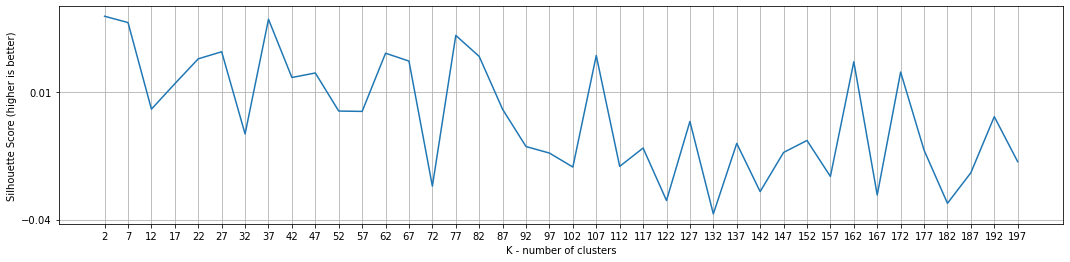

In [38]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [31]:
r_matrix = X_train.groupby(['customer_id', 'product_id'])['star_rating'].min().unstack('product_id', fill_value=0)
kmeans = kmeansClustering(k=2)
kmeans.predict(csr_matrix(r_matrix.values))

In [32]:
r_matrix = pd.concat([r_matrix.reset_index(), pd.DataFrame({'group':kmeans.predictions})], axis=1)
rms, ms, ma = score(kmeans)
print("Results using CF-Kmeans model:\n")
print("Root Mean Square Error: ", rms)
print("Mean Square Error: ", ms)
print("Mean Absolute Error: ", ma)

Results using CF-Kmeans model:

Root Mean Square Error:  1.0924736820487508
Mean Square Error:  1.1934987459691553
Mean Absolute Error:  0.7964043099646887


In [33]:
kmeans.getNRecommendations(10, 13343)

,product_id,rating,count,product_title,product_category
0,B00029U1DU,5.0,45,Verbatim 700MB 52X 80 Minute Branded Recordabl...,Electronics
1,B0036OQU2E,5.0,31,Copco Non-Skid Cabinet Turntable,Home
2,B00005113L,5.0,30,"Cables To Go 18 AWG Universal Power Cord, IEC3...",Electronics
3,B0002XD08Y,5.0,29,"simplehuman Under-Counter Pull-Out Trash Can, ...",Home
4,B005LJQO9G,5.0,25,HDMI-DVI Cables,Electronics
5,B001MSU1HQ,5.0,23,Mediabridge RCA Component Video Cable with Audio,Electronics
6,B00BWJCCI6,5.0,22,Sizzix Big Shot Cutting and Embossing Roller S...,Home
7,B000CR38Y6,5.0,17,Willow Tree Promise,Home
8,B000WV1XGC,5.0,15,Clover Large Pom Pom Maker,Home
9,B00RH340WM,5.0,15,French Coffee & TeaMaker Complete Bundle | 34 ...,Home


In [46]:
r_matrix = X_train.groupby(['customer_id', 'product_id'])['star_rating'].min().unstack('product_id', fill_value=0)
kmeans = kmeansClustering(k=37)
kmeans.predict(csr_matrix(r_matrix.values))

In [47]:
r_matrix = pd.concat([r_matrix.reset_index(), pd.DataFrame({'group':kmeans.predictions})], axis=1)
rms, ms, ma = score(kmeans)
print("Results using CF-Kmeans model:\n")
print("Root Mean Square Error: ", rms)
print("Mean Square Error: ", ms)
print("Mean Absolute Error: ", ma)

Results using CF-Kmeans model:

Root Mean Square Error:  1.5450806509212327
Mean Square Error:  2.38727421785118
Mean Absolute Error:  1.2377172366146751


In [48]:
kmeans.getNRecommendations(10, 13343)

,product_id,rating,count,product_title,product_category
0,B0052SCU8U,5.0,670,AmazonBasics High Speed HDMI Cable,Electronics
1,B00316263Y,5.0,407,BlueRigger Basic High Speed HDMI Cable - 6.6 F...,Electronics
2,B004QK7HI8,5.0,393,"Mohu Leaf 30 TV Antenna, Indoor, 30 Mile Range...",Electronics
3,B0001FTVEK,5.0,378,Sennheiser On-Ear 926MHz Wireless RF Headphone...,Electronics
4,B001TH7T2U,5.0,316,AmazonBasics HDMI to DVI Adapter Cable - 9.8 ...,Electronics
5,B00BEWF4R2,5.0,300,CABTE High speed HDMI 1.4 HDMI cable 10ft 1080...,Electronics
6,B001GTT0VO,5.0,296,Cheetah Mounts ALAMB Articulating Arm (15” Ext...,Electronics
7,B003L1ZYYW,5.0,296,AmazonBasics High Speed HDMI Cable,Electronics
8,B00004T8R2,5.0,258,Panasonic Lightweight Headphones with XBS Port,Electronics
9,B001A5PDKQ,5.0,258,Mediabridge ULTRA Series HDMI Cable (3 Foot) -...,Electronics


## Model 4 - Matrix factorisation using ALS <a name="als"></a>

The major problem faced by the colloborative based filtering is the sparisty of the user-item matrix. Ratings available are very limited and running KNN and Kmeans on such sparse matrix becomes unstable when there are large number of users and items in the system. In such scenarios, to effectively compute the missing values in the user-item matrix, matrix factorisation is used.  
It is a dimensionality reduction method which decompose the user-item interaction matrix into the product of two lower dimensionality rectangular matrices. One matrix can be seen as the user matrix where rows represent users and columns are latent factors. The other matrix is the item matrix where rows are latent factors and columns represent items.  
<img src ="als.png" align = center width="500" height="500"></img>  

In this project, Alternating least squares method is used for the matrix factorisation. By multiplying U and V matrices, we try to reconstruct the original matrix R, by reducing the root mean squared errors between original available ratings from sparse matrix R (m x n dimensions) and constructed dense matrix by multiplying U (m x k dimensions) and V (k x n dimensions) matrices. ALS minimizes two loss functions alternatively; It first holds user matrix fixed and runs gradient descent with item matrix; then it holds item matrix fixed and runs gradient descent with user matrix. This way it is easy to parellelize.  



In [64]:
def getUserItemMatrix(X_train):

    print("Getting 'A' matrix with rows: user and columns: movies...")
    A = X_train.groupby(['customer_id','product_id'])['star_rating'].min().unstack('product_id', fill_value=0)

    print("'A' matrix shape is", A.shape)

    print("Getting 'R' Binary Matrix of rating or no rating...")
    R = A>0; R[R == True] = 1; R[R == False] = 0; R = R.astype(np.float64, copy=False)

    return A, R

class ALSFiltering:  
    def getPredictions(self, customer_id, product_id):
        #Check if product_id exists in r_matrix
        if product_id in A:
            mean_rating = PR.loc[customer_id,product_id]
        else:        
            #Default to a rating of 3.0 in the absence of any information
            mean_rating = 3.0 
   
        return mean_rating
    
    def runALS(self, A, R, n_factors, n_iterations, lambda_):
        '''
        Runs Alternating Least Squares algorithm in order to calculate matrix.
        :param A: User-Item Matrix with ratings
        :param R: User-Item Matrix with 1 if there is a rating or 0 if not
        :param n_factors: How many factors each of user and item matrix will consider
        :param n_iterations: How many times to run algorithm
        :param lambda_: Regularization parameter
        :return:
        '''
        print("Initiating ")
        print("R shape", R.shape)
        lambda_ = lambda_; n_factors = n_factors; n, m = A.shape; n_iterations = n_iterations
        Users = 3 * np.random.rand(n, n_factors)
        Items = 3 * np.random.rand(n_factors, m)

        def get_error(A, Users, Items, R):
            # This calculates the MSE of nonzero elements
            return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

        MSE_List = []

        print("Starting Iterations")
        for iter in range(n_iterations):
            for i, Ri in enumerate(R):
                nui = np.count_nonzero(Ri) # Number of items user i has rated
                if (nui == 0): nui = 1 # Be aware of zero counts!
                Ri_nonzero = np.nonzero(Ri)[0]
                Items_Ri = Items[:, Ri_nonzero]
                A_Ii = A[i, Ri_nonzero]
                Ai = np.dot(Items_Ri, Items_Ri.T) + lambda_ * nui * np.eye(n_factors)
                Vi = np.dot(Items_Ri, A_Ii.T)
                Users[i] = np.linalg.solve(Ai, Vi).T
            print("Error after solving for User Matrix:", get_error(A, Users, Items, R))

            for j, Rj in enumerate(R.T):
                nmj = np.count_nonzero(Rj) # Number of users that rated item j
                if (nmj == 0): nmj = 1 # Be aware of zero counts!
                Rj_nonzero = np.nonzero(Rj)[0]
                Users_Rj = Users.T[:, Rj_nonzero]
                A_Rj = A[Rj_nonzero, j]
                Aj = np.dot(Users_Rj, Users_Rj.T) + lambda_ * nmj * np.eye(n_factors)
                Vj = np.dot(Users_Rj, A_Rj)
                Items[:,j] = np.linalg.solve(Aj, Vj)
            print("Error after solving for Item Matrix:", get_error(A, Users, Items, R))

            MSE_List.append(get_error(A, Users, Items, R))
            print("%sth iteration is complete..." % iter)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
        plt.title('Python Implementation MSE by Iteration \n with %d customers and %d products' % A.shape);
        plt.show()
        return Users, Items
    
    def getNRecommendations(self, n, customer_id):
        r_matrix = A.reset_index()
        # get customer index
        idx = r_matrix[r_matrix.customer_id == customer_id].index.values[0]
        # get all products customer not reviwed
        plist = r_matrix.iloc[idx,:][map(lambda x :x not in ['product_id','customer_id'], list(r_matrix.columns))].to_frame().reset_index()
        plist.columns = ['product', 'rating']
        r_matrix = pd.DataFrame()
        plist = np.array(plist[plist.rating==0]['product'])
        rec = []
        for product in plist:
            rec.append([product, self.getPredictions(customer_id, product)])
        rec = pd.DataFrame(rec, columns=['product_id','rating'])  
        def getCount(p):
            return np.count_nonzero(A.loc[:,[p]])
        rec['count'] =  rec['product_id'].apply(getCount)
        most_popular = rec.sort_values(['rating','count'],ascending=False).iloc[:n,:]
        most_popular = pd.merge(most_popular, product_data[['product_id', 'product_title', 'product_category']],
                how='left', on=['product_id'])
        return most_popular

X_train = pd.read_csv(os.path.join(project_dir, "X_train.csv"), header=0, engine='python')
X_test = pd.read_csv(os.path.join(project_dir, "X_test.csv"), header=0, engine='python')
y_train = pd.read_csv(os.path.join(project_dir, "y_train.csv"), header=0, engine='python')
y_test = pd.read_csv(os.path.join(project_dir, "y_test.csv"), header=0, engine='python') 
product_data = pd.DataFrame(X_train.groupby(['product_id', 'product_category', 'product_title'])['star_rating'].count()).reset_index().loc[:,['product_id', 'product_category', 'product_title']]


In [51]:
A, R = getUserItemMatrix(X_train)
review_data = pd.read_csv(os.path.join(project_dir, "X_train.csv"), header=0, engine='python', usecols=['review_id', 'product_id', 'product_category', 'product_title'])

Getting 'A' matrix with rows: user and columns: movies...
'A' matrix shape is (37241, 5513)
Getting 'R' Binary Matrix of rating or no rating...


Initiating 
R shape (37241, 5513)
Starting Iterations
Error after solving for User Matrix: 0.15742669266867437
Error after solving for Item Matrix: 0.38324974157150365
0th iteration is complete...
Error after solving for User Matrix: 0.09643889938529947
Error after solving for Item Matrix: 0.21064669699618882
1th iteration is complete...
Error after solving for User Matrix: 0.07787097323682132
Error after solving for Item Matrix: 0.15914190307359052
2th iteration is complete...
Error after solving for User Matrix: 0.06852731820208931
Error after solving for Item Matrix: 0.13135591467803925
3th iteration is complete...
Error after solving for User Matrix: 0.06307285872998782
Error after solving for Item Matrix: 0.1137941898348555
4th iteration is complete...
Error after solving for User Matrix: 0.059691641706808525
Error after solving for Item Matrix: 0.10175946818331479
5th iteration is complete...
Error after solving for User Matrix: 0.057495075427487365
Error after solving for Item M

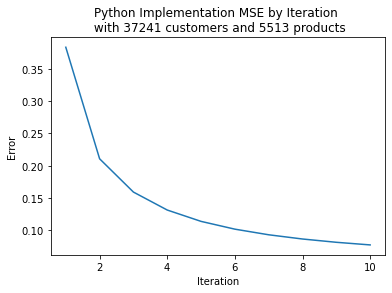

In [52]:
als = ALSFiltering()
Users, Items = als.runALS(A.values, R.values, n_factors = 8, n_iterations = 10, lambda_ = .1)

In [65]:
# prediction matrix
PR = np.dot(Users, Items)
PR = pd.DataFrame(data = PR, index = A.index, columns = A.columns)
rms, ms, ma = score(als)
print("Results using Matrix Factorisation:\n")
print("Root Mean Square Error: ", rms)
print("Mean Square Error: ", ms)
print("Mean Absolute Error: ", ma)

Results using Matrix Factorisation:

Root Mean Square Error:  1.2395551132946747
Mean Square Error:  1.5364968788949738
Mean Absolute Error:  0.9433608538568954


In [66]:
als.getNRecommendations(10, 13343)

,product_id,rating,count,product_title,product_category
0,B000MI3HJQ,5.306623,27,Vornado 733 Full-Size Whole Room Air Circulato...,Home
1,B000HVTC5G,5.295044,28,Surround Air XJ-3800 Large Intelligent Air Pur...,Home
2,B00M58CMYC,5.236016,27,Bose SoundLink On-Ear Bluetooth Headphones - B...,Electronics
3,B00K589F8A,5.232008,61,Photive Hydra Wireless Bluetooth Speaker. Wate...,Electronics
4,B000NLUSLM,5.208565,19,Maha PowerEx MH-C9000 WizardOne Charger-Analyz...,Electronics
5,B004EBX5GW,5.202430,70,Mediabridge ULTRA Series RCA Y-Adapter (12 Inc...,Electronics
6,B000IV2WAW,5.197126,70,Sanyo Eneloop AA NiMH Pre-Charged Rechargeable...,Electronics
7,B0016N3PKW,5.195713,10,Clover Takumi Getaway Soft Touch Crochet Hooks...,Home
8,B003PWK2A8,5.195681,100,SafeRest Premium Hypoallergenic Waterproof Mat...,Home
9,B00029U1DU,5.193858,45,Verbatim 700MB 52X 80 Minute Branded Recordabl...,Electronics


## Model 5 - Content based filtering using BERT <a name="bert"></a>

All the colloborative filtering recommendation techniques discussed in the earlier sections suffer from cold-start problem. Cold start is the problem which occurs when there are new users and items in the system. Product cold-start occurs when  the product has not received enough reviews and it is difficult to compute the simmilarity of products based on interactions. Customer cold-start problem occurs when customer has not given enough reviews and finding the simmilar users is a challenge. In such situations content-based filtering recommendation technique is a better choice.

Content-based methods try to use the content or attributes of the item, together with some notion of similarity between two pieces of content, to generate similar items with respect to the given item. In this case, cosine similarity is used to determine the nearest user or item to provide recommendations.  
<img src ="cbs.png" align = center width="200" height="200"></img>  

In our dataset, product title information can be leveraged to generate the features and using those features simmilar items can be recommended to the user. In this project, a pretrained BERT model is used to generate the sentence embeddings from the product title and then cosine simmilarity measure is used to find the simmilar products based on the features.

In [136]:
from scipy.spatial.distance import cosine

#For Bert
import torch
from transformers import BertTokenizer
from transformers.modeling_bert import BertModel

def getSentenceEmbeddings(decription):
    token_tensor = "[CLS] " + decription + " [SEP]"
    token_tensor = tokenizer.tokenize(token_tensor)
    token_tensor = tokenizer.convert_tokens_to_ids(token_tensor)
    segments_tensors = [1] * len(token_tensor)
    segments_tensors = torch.tensor([segments_tensors])
    token_tensor = torch.tensor([token_tensor])
    with torch.no_grad():
        output = model(token_tensor, segments_tensors)
        token_vecs = output[2]
        sentence_embedding = torch.mean(token_vecs[-2][0], dim=0)
    return sentence_embedding

class ContentBasedFiltering:
  
    def getPredictions(self, customer_id, product_id):
        mean_rating = 3
        # get embedding of the product title
#         embedding = X_test[(X_test['customer_id'] == customer_id)
#                            & (X_test['product_id'] == product_id)]['sentence_embedding'].values[0]
        embedding = product_data[product_data.product_id == product_id]['sentence_embedding'].values[0]
        # get reviewed products from user profile
        user_products = X_train[(X_train['customer_id'] == customer_id) 
                                & (X_train['star_rating'] > 0)].loc[:,['product_id','sentence_embedding','star_rating']]
         # find simmilarity of reviewed products in user profile
        user_products.loc[:,'cosine_score'] = user_products.apply(lambda row: 1 - cosine(row['sentence_embedding'], 
                                                                                         embedding), axis=1)
        simmilar_products = user_products[user_products.cosine_score > 0.75]
        if simmilar_products.empty:
            mean_rating = 3
        else: 
            mean_rating = simmilar_products['star_rating'].mean()
        return mean_rating
    
    def getNRecommendations(self, n, customer_id):
        # get products not rated by customer
        plist = X_train[X_train.customer_id == customer_id]['product_id'].to_frame()
        plist = np.array(X_train[~(X_train.product_id.isin(plist.product_id))]['product_id'])
        rec = []
        for product in plist:
            rec.append([product, self.getPredictions(customer_id, product)])
        rec = pd.DataFrame(rec, columns=['product_id','rating'])   
        rec['count'] =  rec['product_id'].apply(getCount)
        most_popular = rec.sort_values(['rating','count'],ascending=False).iloc[:n,:]
        most_popular = pd.merge(most_popular, product_data[['product_id', 'product_title', 'product_category']],
                how='left', on=['product_id'])
        return most_popular
    
X_train = pd.read_csv(os.path.join(project_dir, "X_train.csv"), header=0, engine='python')
X_test = pd.read_csv(os.path.join(project_dir, "X_test.csv"), header=0, engine='python')
y_train = pd.read_csv(os.path.join(project_dir, "y_train.csv"), header=0, engine='python')
y_test = pd.read_csv(os.path.join(project_dir, "y_test.csv"), header=0, engine='python') 
product_data = pd.DataFrame(X_train.groupby(['product_id', 'product_category', 'product_title'])['star_rating'].count()).reset_index().loc[:,['product_id', 'product_category', 'product_title']]

In [123]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1)
          )
        )
        (in

In [124]:
product_data = pd.concat([X_train.loc[:,['product_id','product_title','product_category','star_rating']],
                          X_test.loc[:,['product_id','product_title','product_category','star_rating']]])
product_data = product_data.groupby(['product_id','product_title','product_category']).count().reset_index()
product_data = product_data.loc[:,['product_id','product_title','product_category']]
product_data.loc[:,'sentence_embedding'] = product_data.loc[:,'product_title'].apply(getSentenceEmbeddings)

In [137]:
X_train  = pd.merge(X_train, product_data[['product_id', 'product_title', 'product_category','sentence_embedding']],
                how='left', on=['product_id', 'product_title', 'product_category'])

X_train.columns = ['id','customer_id','review_id','product_id','product_title','product_category','star_rating','review_date','year','sentence_embedding']
idx = X_train[X_train.duplicated(['id'])].index
X_train = X_train.loc[~X_train.index.isin(idx),['customer_id','product_id','star_rating','product_title','product_category','sentence_embedding']]

In [138]:
X_test  = pd.merge(X_test, product_data[['product_id', 'product_title', 'product_category','sentence_embedding']],
                how='left', on=['product_id', 'product_title', 'product_category'])
X_test.columns = ['id','customer_id','review_id','product_id','product_title','product_category','star_rating','review_date','year','sentence_embedding']
idx = X_test[X_test.duplicated(['id'])].index
X_test = X_test.loc[~X_test.index.isin(idx),['customer_id','product_id','star_rating','product_title','product_category','sentence_embedding']]

In [134]:
print(X_train['sentence_embedding'])
print(X_test['sentence_embedding'])

0         [tensor(0.1428), tensor(-0.0208), tensor(0.067...
1         [tensor(-0.1214), tensor(0.0390), tensor(1.053...
2         [tensor(0.0905), tensor(0.0414), tensor(0.6481...
3         [tensor(-0.0682), tensor(-0.1636), tensor(0.62...
4         [tensor(0.2021), tensor(0.3728), tensor(0.7874...
                                ...                        
177986    [tensor(-0.0011), tensor(0.3190), tensor(-0.02...
177987    [tensor(0.0823), tensor(-0.2703), tensor(0.335...
177988    [tensor(0.1041), tensor(-0.1652), tensor(0.993...
177989    [tensor(0.0208), tensor(-0.2914), tensor(-0.22...
177990    [tensor(0.2249), tensor(-0.2081), tensor(0.862...
Name: sentence_embedding, Length: 177991, dtype: object
0        [tensor(-0.1315), tensor(0.1359), tensor(0.435...
1        [tensor(-0.1546), tensor(0.3477), tensor(1.149...
2        [tensor(-0.0856), tensor(-0.1184), tensor(0.42...
3        [tensor(0.0280), tensor(-0.2511), tensor(1.069...
4        [tensor(0.0358), tensor(-0.4994), tenso

In [128]:
cbf = ContentBasedFiltering()
rms, ms, ma = score(cbf)
print("Results using Content based filtering-BERT:\n")
print("Root Mean Square Error: ", rms)
print("Mean Square Error: ", ms)
print("Mean Absolute Error: ", ma)

Results using Content based filtering-BERT:

Root Mean Square Error:  1.192514254684794
Mean Square Error:  1.4220902476264299
Mean Absolute Error:  0.7953073250458133


In [139]:
cbf.getNRecommendations(10, 13343)

KeyboardInterrupt: 

# 5. Conclusion <a name="conclusion"></a>

In this project, 5 models of recommendations were evaluated on a subset of Amazon reviews dataset and below table summarises the results obtained.  
<img src ="conclusion.png" align = left width="500" height="500"></img>  


The baseline model which predicted the rating based on average rating of the product has a reasonable RMSE of 1.744. The reason it achieved comparable performance to the other models is because the mean ratings in our dataset are mostly high ranging from 3 to 5 and the model also predicted ratings close to the mean ratings. The user-based colloborative filtering method which utilised KNN model to find the nearest neighbors took a great deal of time in computing the ratings of test dataset. However, only a slight improvement was observed in the performance of the model. The item-based colloborative method gave a better performance than user-based because the model starts filtering with item first instead of users and in our dataset there are much less products than there are customers. Kmeans clustering models gave the best performance in this project with RMSE of 1.093. With matrix factorisation, the prediction time of ratings become really fast and it performed better than KNN-based models. To address the cold-start problem, product title information was leveraged and simmilar items was found using product features. A pretrained version of BERT was used to extract those features. This model also gave satisfactory performance as compared to other models. 

# 6. Future work <a name="future"></a>

In this project, only a subset of dataset was utilised for evaluating the performance of models because of the computation limits of the local machine. For future, evaluation can be performed on high performant machines using a larger dataset. It would also be intersting to see the performance of models by using a hybrid approach of combining collaborative and content-based methods, which helps to avoid certain limitations of content-based and collaborative systems. For content-based filtering model, a comparison of other BERT models can be performed other than the bert_base_uncased which was used in this project.


# 7. References

 - Shani G., Gunawardana A. (2011) Evaluating Recommendation Systems. In: Ricci F., Rokach L., Shapira B., Kantor P. (eds) Recommender Systems Handbook. Springer, Boston, MA. https://doi.org/10.1007/978-0-387-85820-3_8
 - https://github.com/PacktPublishing/Statistics-for-Machine-Learning  
 - https://github.com/PacktPublishing/Hands-On-Recommendation-Systems-with-Python  
 - https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/  
 - https://medium.com/datadriveninvestor/how-to-built-a-recommender-system-rs-616c988d64b2  